# Basic Random Forest Model Kaggle Score 0.953
> Some code referenced directly from other Kaggle workbooks

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png
- author: Tracy Dinh

This is a Colab notebook. Basic Random Forest Model without any hyperparameter tuning and feature engineering. Kaggle Score 0.953. This can be a baseline model

In [1]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 30.8MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 194kB 45.1MB/s 
     |████████████████████████████████| 1.2MB 44.8MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt

from fastbook import *
from fastai.tabular.all import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import random as rd


pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

## Download Data From Kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
path = Path('/content/gdrive/MyDrive/Kaggle/' + 'data/homesite-quote')
path.mkdir(parents=True, exist_ok=True)
path


Path('/content/gdrive/MyDrive/Kaggle/data/homesite-quote')

In [6]:
!kaggle competitions download -c homesite-quote-conversion -p /content/gdrive/MyDrive/Kaggle/data/homesite-quote


 89% 33.0M/37.1M [00:00<00:00, 63.7MB/s]
100% 37.1M/37.1M [00:00<00:00, 83.8MB/s]
  0% 0.00/258k [00:00<?, ?B/s]
100% 258k/258k [00:00<00:00, 36.1MB/s]
 53% 13.0M/24.7M [00:00<00:00, 68.0MB/s]
100% 24.7M/24.7M [00:00<00:00, 82.5MB/s]


In [7]:
! unzip -q -n '{path}/train.csv.zip' -d '{path}'
! unzip -q -n '{path}/test.csv.zip' -d '{path}'

## Import Data

In [8]:
#data import
df = pd.read_csv(path/'train.csv', low_memory=False)
test_df = pd.read_csv(path/'test.csv', low_memory=False)

##Data Prep

In [9]:
# ## Dropping Original_quote_date
def drop_cols(df):
    df.drop(['Original_Quote_Date'],axis=1,inplace=True)
    return df
train_df=df
train_df = drop_cols(train_df)
test_df = drop_cols(test_df)


In [10]:
# ## Removing columns with na values
cols_to_delete = train_df.isna().sum()[train_df.isna().sum() > 0].index

def drop_cols_from_list(df,cols_to_delete):
    df.drop(cols_to_delete,axis=1,inplace=True)
    return df

train_df = drop_cols_from_list(train_df,cols_to_delete)
test_df = drop_cols_from_list(test_df,cols_to_delete)

In [11]:
#dropping categorical columns with nunique > 2
cols_to_drop = []

for i in set(train_df.columns) - set(train_df._get_numeric_data().columns):
    if (train_df.loc[:,i].nunique() >= 3):
        cols_to_drop.append(i)
        
train_df = drop_cols_from_list(train_df,cols_to_drop)
test_df = drop_cols_from_list(test_df,cols_to_drop)

In [12]:
#one hot encoding:
cls_to_encode = set(train_df.columns) - set(train_df._get_numeric_data().columns)

def ohe(df,cls_to_encode):
    df = pd.get_dummies(df,columns=cls_to_encode,drop_first=True)
    return df

train_df = ohe(train_df,cls_to_encode)
test_df = ohe(test_df,cls_to_encode)


In [13]:
#dropping any extra columns in test set that are not present in train set
test_df.drop(list(set(test_df.columns) - set(train_df.columns)),axis=1,inplace=True)


## Model

In [14]:
#Assigning dependent and independent variables
X = train_df.drop('QuoteConversion_Flag',axis=1)
y = train_df.QuoteConversion_Flag


In [15]:
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)


In [16]:
train_idx=pd.DataFrame(X_train.index)
valid_idx=pd.DataFrame(X_test.index)

In [17]:
train_idx.to_csv(path/'train_idx.csv',index=False)
valid_idx.to_csv(path/'valid_idx.csv',index=False)

In [18]:
#training Randomforest

rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [19]:
#Print Accuracy Score
print("train accuracy score = ", accuracy_score(y_train,rfc.predict(X_train)))
print("test accuracy score = ", accuracy_score(y_test,rfc.predict(X_test)))


train accuracy score =  0.9999952061821076
test accuracy score =  0.9162623919004429


In [20]:
#Print ROC AUC Score
roc_auc_score(y_train,rfc.predict(X_train)),roc_auc_score(y_test,rfc.predict(X_test))

(0.9999872171801099, 0.8078645543138884)

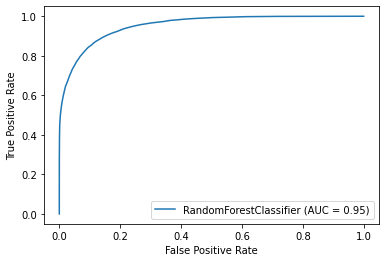

In [21]:
plot_roc_curve(rfc, X_test, y_test)
plt.show()

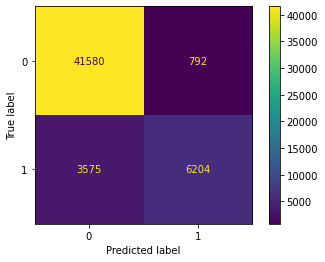

In [22]:
plot_confusion_matrix(rfc, X_test, y_test,values_format='d')
plt.show()

In [23]:
#submitting output
output_submission = pd.DataFrame(zip(test_df.QuoteNumber,rfc.predict_proba(test_df)[:,1]), columns = ['QuoteNumber','QuoteConversion_Flag'])
output_submission.to_csv(path/'output_submission.csv',index=False)